In [32]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [33]:
def load_data(L,temp,MCS):
    return np.fromfile(f"../ising_wolff/dataIsing2D_L{L}/config_L{L}_T{temp:.3f}.bin",dtype = np.int32).reshape(MCS,L**2)

In [34]:
def scorefunc(x, A,g):
    s1 = torch.matmul(x, A)
    score = -s1 + g*(x**2 - 1)*x
    return score

In [35]:
def gen_noisy_data(x0,step,temp,dt,device = "cpu"):
    x0 = x0.to(device)
    step = step.to(device)
    noise = torch.randn_like(x0).to(device)
    exp_t =torch.exp(-dt*(step+1)).view(-1, 1)
    std_t = torch.sqrt(temp*(1-exp_t*exp_t))
    noisy_data = x0*exp_t + noise*std_t
    return noisy_data, -noise

In [42]:
L = 10
N = L**2
temp = 2.72

MCS = 200000
P = 50000

T = 8

nSteps = 300
dt = 0.02

data = load_data(L,temp,MCS)
data = torch.from_numpy(data).to(torch.float32)

In [44]:
A = torch.randn((nSteps,N,N))/N**0.5
A = A.requires_grad_(True)
g = torch.randn((nSteps,1))/N**0.5
#tau = torch.randn((nSteps,1))/N**0.5
g = g.requires_grad_(True)
#tau = tau.requires_grad_(True)
n_epochs = 500
batch_size = 256
learning_rate = 0.1
optimizer = torch.optim.Adam([A,g],lr = learning_rate,weight_decay=1e-05)
decay_rate = 1-np.log(10)/n_epochs
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=decay_rate)
myloss = torch.nn.MSELoss()


In [45]:
500*512/P

5.12

In [46]:
for epochs in range(n_epochs):
    idx = np.random.choice(range(P),batch_size,replace =False)
    loss = 0
    for tt in range(nSteps):
        tnow = torch.Tensor([[tt+1,]])
        x_train,y_train = gen_noisy_data(data[idx],tnow,T,dt)
        loss += (myloss(scorefunc(x_train,A[tt],g[tt]),y_train) +  0.025* torch.sum(torch.abs(A[tt])))/nSteps 
        #loss += (myloss(scorefunc(x_train,A[tt],B[tt]),y_train))/nSteps 
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    scheduler.step()
    if (epochs+1)%100 ==0:
        print(f"epoch = {epochs+1}, loss = {loss.item()}, lr = {optimizer.param_groups[0]['lr']}")


epoch = 100, loss = 2.2913031578063965, lr = 0.06302865857645837
epoch = 200, loss = 1.6462547779083252, lr = 0.039726118019477646
epoch = 300, loss = 1.2127563953399658, lr = 0.02503883929217749
epoch = 400, loss = 0.9304654002189636, lr = 0.015781644528974674
epoch = 500, loss = 0.7490829825401306, lr = 0.009946958847917782


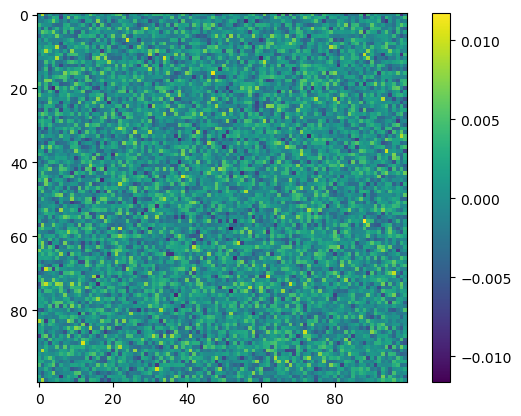

In [47]:
plt.imshow((-A[0].detach().numpy() + np.diag(np.diag(A[0].detach().numpy())))/np.sqrt(T*(1-np.exp(-2*dt))))
plt.colorbar()

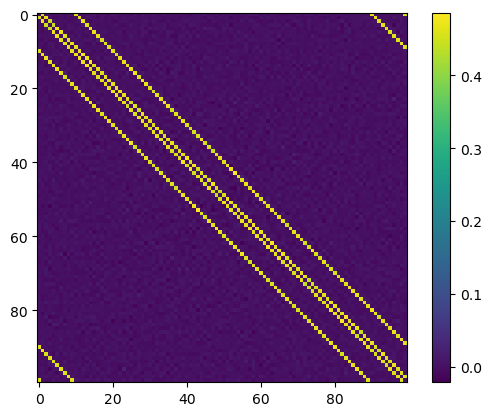

In [48]:
Jtrue = np.linalg.inv(np.cov(data.T))
plt.imshow(-Jtrue+np.diag(np.diag(Jtrue)) )
plt.colorbar()

In [49]:
def backward(xT,A,g,temp,nSteps,dt,full_traj = False,device = "cpu"):
    P = xT.shape[0]
    N = xT.shape[1]
    nbatches = 50
    batch_size = int(P/nbatches)
    if(full_traj):
        x_recon = torch.Tensor(P,nSteps,N)
        x_recon[:,-1,:] = xT
    else:
        x_recon = xT
    with torch.no_grad():
        for tt in range(nSteps)[::-1]:
            std = np.sqrt(2*(temp)*dt)*torch.randn_like(xT)
            den = np.sqrt(temp*(1-np.exp(-2*(tt+1))))
            
            for n in range(nbatches):
                if(full_traj):
                    score = scorefunc(x_recon[n*batch_size:(n+1)*batch_size,tt,:], A[tt],g[tt])/den
                    x_recon[n*batch_size:(n+1)*batch_size,tt-1,:] = x_recon[n*batch_size:(n+1)*batch_size,tt,:]*(1+dt) + 2*temp*score*dt + std[n*batch_size:(n+1)*batch_size]
                else:
                    score = scorefunc(x_recon[n*batch_size:(n+1)*batch_size], A[tt],g[tt])/den
                    x_recon[n*batch_size:(n+1)*batch_size] = x_recon[n*batch_size:(n+1)*batch_size]*(1+dt)+ 2*temp*score*dt + std[n*batch_size:(n+1)*batch_size]
                del score
        
    return x_recon

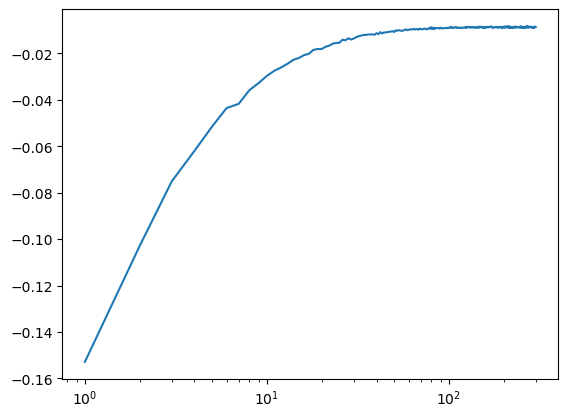

In [50]:
A_optim = A.detach()
g_optim = g.detach().reshape(nSteps)
plt.plot([*range(1,1+nSteps)],g_optim.numpy())
#plt.axvline(np.log(N))
plt.xscale("log")

In [51]:
xT = np.sqrt(T)*torch.randn((P,N))
x_recon = backward(xT,A_optim,g_optim,T,nSteps,dt).numpy()

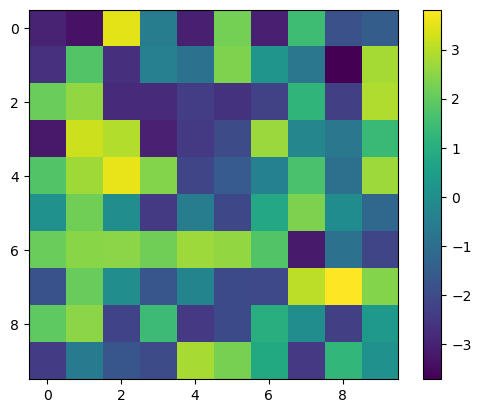

In [52]:
plt.imshow(x_recon[0].reshape(L,L))
plt.colorbar()

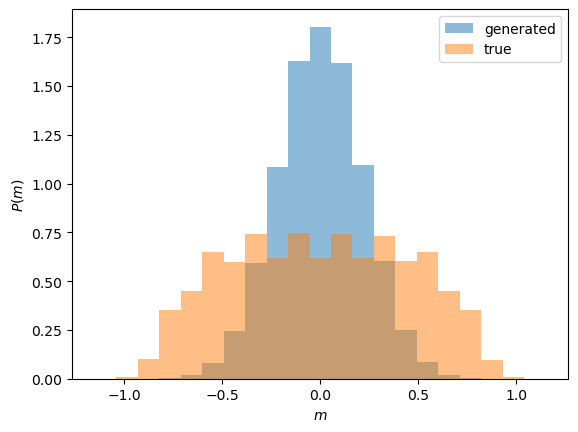

In [53]:
plt.hist(np.mean(x_recon,axis = 1),range=(-1.15,1.15),bins = 21,alpha = 0.5,density = True, label = "generated")
plt.hist(np.mean(data.numpy(),axis = 1),range=(-1.15,1.15),bins = 21,alpha = 0.5,density = True, label = "true")
plt.ylabel(r"$P(m)$")
plt.xlabel(r"$m$")
plt.legend()

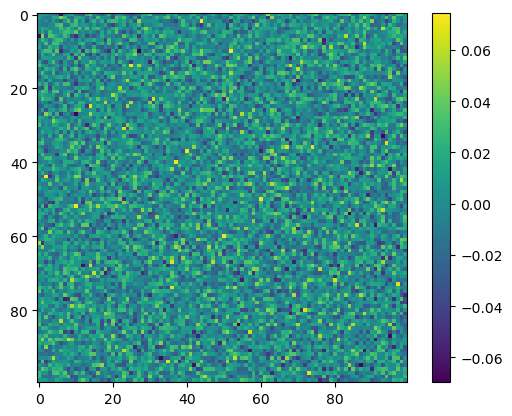

In [54]:
Jpred = np.cov(x_recon.T)
Jpred = Jpred - np.diag(np.diag(Jpred))
plt.imshow(Jpred)
plt.colorbar()

(array([  10.,   57.,  508., 1806., 3785., 4833., 4591., 3588., 2731.,
        2193., 2133., 2433., 2852., 3846., 4769., 4707., 3394., 1378.,
         335.,   51.]),
 array([-5.05466461, -4.56763411, -4.08060312, -3.59357262, -3.10654187,
        -2.61951113, -2.13248038, -1.64544976, -1.15841901, -0.67138833,
        -0.18435764,  0.30267304,  0.78970373,  1.27673447,  1.7637651 ,
         2.25079584,  2.73782659,  3.22485733,  3.71188784,  4.19891882,
         4.68594933]),
 <BarContainer object of 20 artists>)

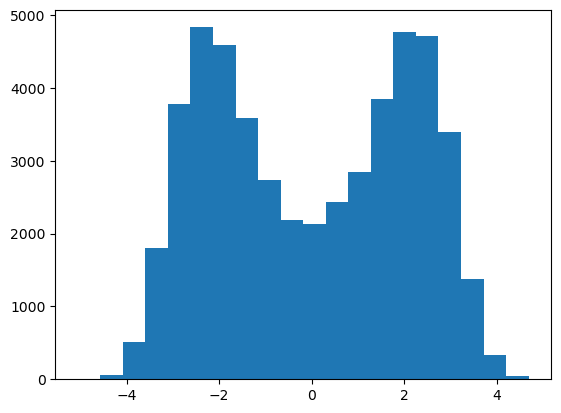

In [55]:
plt.hist(x_recon[:,10],bins = 20)